# Anomaly Detection in Network Traffic Using Hidden Markov Models

**Author**: Marie Vetluzhskikh, 120143991
**Tool:** hmmlearn (Gaussian HMMs)  
**Focus:** Experimental evaluation of HMM suitability for network traffic anomaly detection
**Reference:** For the theoretical background and API description, please see `HMMlearn.API.ipynb`

---

### High-level goal

In this notebook, I present the core experimental results of the project.  

Rather than optimizing performance at all costs, my objective is to **evaluate whether Gaussian HMMs are an appropriate modeling choice for network traffic anomaly detection**, and to empirically demonstrate their limitations.

`HMMlearn.API.ipynb` introduces the theoretical background and API details. Here, I focus strictly on modeling decisions, experiments, and results.


# Imports and Installation

Let's install all the necessary packages and libraries.

In [1]:
!pip install hmmlearn

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score

from hmmlearn.hmm import GaussianHMM

import sys
#sys.path.append('/content/HMMlearn_utils.py')
import HMMlearn_utils as utils

import warnings
warnings.filterwarnings("ignore")

np.random.seed(42)


## Modeling assumptions (critical reminder)

Gaussian HMMs assume:

1. **First-Order Markov Property (Memory-1)**

Ant hidden state at time *t* depends ONLY on the state at *t−1*

2. **Stationary Property**  
Transition probabilities do not change over time

3. **Emission model correctness**  
Observations are generated from *Gaussian* distributions conditioned on the hidden state

4. **Meaningful latent regimes**  
The system repeatedly visits a small number of hidden states


**Problem:** Modern network traffic often violates all four assumptions. This notebook investigates the consequences of these violations


## Part I: UNSW-NB15 (Demonstration of dataset–model mismatch)

The UNSW-NB15 dataset is **not sequential**. Here each row is an independent flow record.

This section is included only to demonstrate why such datasets are incompatible with HMMs. Results here are NOT interpreted as meaningful anomaly detection performance!


## Data Preprocessing and EDA
### Data Preparation:
Preprocess the network traffic data, handling missing values and normalizing features.

In [3]:
df_unsw = pd.read_csv('./content/UNSW_NB15_training-set.csv')
print(df_unsw.shape)
print(df_unsw.head())

(82332, 45)
   id       dur proto service state  spkts  dpkts  sbytes  dbytes  \
0   1  0.000011   udp       -   INT      2      0     496       0   
1   2  0.000008   udp       -   INT      2      0    1762       0   
2   3  0.000005   udp       -   INT      2      0    1068       0   
3   4  0.000006   udp       -   INT      2      0     900       0   
4   5  0.000010   udp       -   INT      2      0    2126       0   

          rate  ...  ct_dst_sport_ltm  ct_dst_src_ltm  is_ftp_login  \
0   90909.0902  ...                 1               2             0   
1  125000.0003  ...                 1               2             0   
2  200000.0051  ...                 1               3             0   
3  166666.6608  ...                 1               3             0   
4  100000.0025  ...                 1               3             0   

   ct_ftp_cmd  ct_flw_http_mthd  ct_src_ltm  ct_srv_dst  is_sm_ips_ports  \
0           0                 0           1           2               

We have plenty of columns and numerous rows, each represents a separate traffic note. They are NOT connected temporally or sequentially. This dataset is great for classificaiton-based anomaly detection (e.g., using random forests). However, for HMMs this is no good since a) there are no obvious hidden or observable states and b) we cannot connect different states with one another to use the Markov assumption


But we will try to work around it. We first create two behaviour classes: normal and attack, which are more or less balanced

In [4]:
numeric_cols = df_unsw.select_dtypes(include=["int64", "float64"]).columns
df_unsw = df_unsw[numeric_cols].dropna()

normal_df = df_unsw[df_unsw["label"] == 0].drop(columns=["label"])
attack_df = df_unsw[df_unsw["label"] == 1].drop(columns=["label"])

print(f"Normal traffic: {normal_df.shape}, Attack traffic: {attack_df.shape}")

Normal traffic: (37000, 40), Attack traffic: (45332, 40)


Then we standartize them

In [5]:
scaler = StandardScaler()
normal_scaled = scaler.fit_transform(normal_df)
attack_scaled = scaler.transform(attack_df)

# Feature Engineering: Artificial sequence construction (known to be invalid)

To force this dataset into an HMM framework, we artificially group independent rows into fixed-length sequences.

**Important:** these sequences have **no temporal meaning**! This violate the core assumptions of HMMs

In [6]:
# artificial segmentation
def chunk_sequences(data, seq_len=50):
    return [data[i:i+seq_len] for i in range(0, len(data) - seq_len, seq_len)]

normal_sequences = chunk_sequences(normal_scaled)

X_train = np.vstack(normal_sequences)
lengths = [len(seq) for seq in normal_sequences]

# Model Training:

Implement a Gaussian HMM using HMMlearn to model normal network behavior.

In [7]:
hmm_unsw = GaussianHMM(
    n_components=3,
    covariance_type="diag",
    n_iter=100,
    random_state=42
)

hmm_unsw.fit(X_train, lengths)

GaussianHMM(n_components=3, n_iter=100, random_state=42)

In [8]:
# show model convergence and iterations
print("Converged:", hmm_unsw.monitor_.converged)
print("Iters:", hmm_unsw.monitor_.iter)
print("LL history (last 10):", list(hmm_unsw.monitor_.history)[-10:])

Converged: True
Iters: 7
LL history (last 10): [-2035895.1256031692, -446072.13948299206, 476362.7512786715, 673472.0242806701, 735564.5537041859, 773215.5162116649, 773215.5162116643]


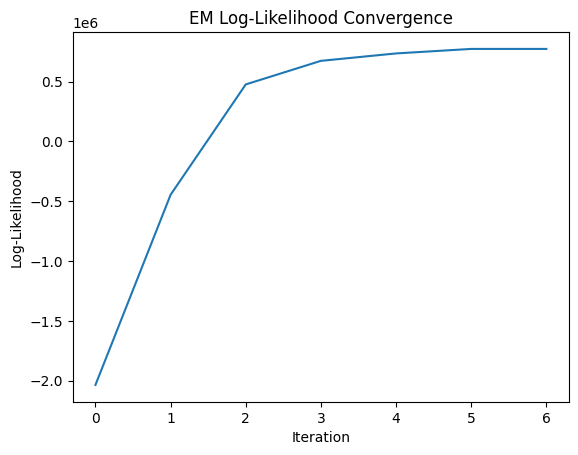

In [9]:
plt.plot(hmm_unsw.monitor_.history)
plt.title("EM Log-Likelihood Convergence")
plt.xlabel("Iteration")
plt.ylabel("Log-Likelihood")
plt.show()

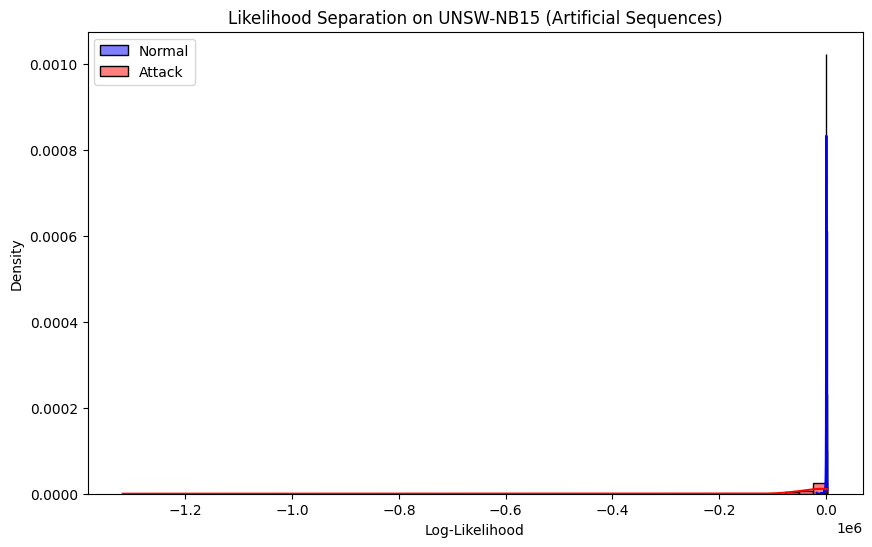

In [10]:
# score artificial sequences
normal_scores = [
    hmm_unsw.score(seq)
    for seq in normal_sequences
]

attack_sequences = chunk_sequences(attack_scaled)
attack_scores = [
    hmm_unsw.score(seq)
    for seq in attack_sequences
]

plt.figure(figsize=(10, 6))
sns.histplot(normal_scores, bins=50, kde=True, label="Normal", color="blue", stat="density")
sns.histplot(attack_scores, bins=50, kde=True, label="Attack", color="red", stat="density")
plt.xlabel("Log-Likelihood")
plt.ylabel("Density")
plt.title("Likelihood Separation on UNSW-NB15 (Artificial Sequences)")
plt.legend()
plt.show()

The model converges in only 7 EM iterations, which is abnormally quickly. This indicates a rapid numerical convergence.

In addition, artificially constructed sequences corresponding to normal traffic show systematically higher log-likelihoods than attack sequences. This produces a visible separation between likelihood distributions.

However, this apparent separability is misleading:
- The sequences are not temporally meaningful
- Separation is driven by static feature distributions
- Transition dynamics have no semantic interpretation

Therefore, the model appears effective but really it fundamentally violates HMM assumptions!

---

To fully justify this conclusion, let's prove that the problem isn't in a randomly chosen model parameters. Let's experiment with different number of components and increase the number of iterations.

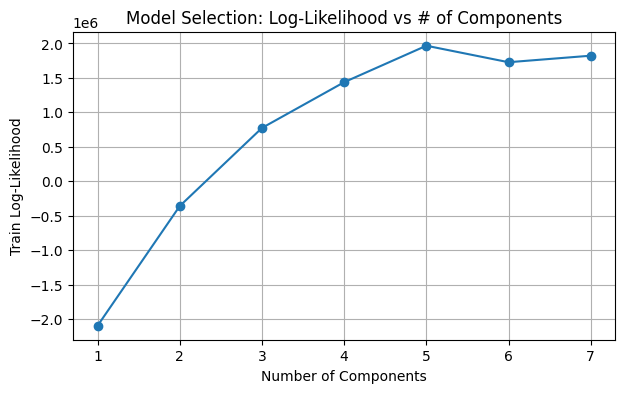

In [11]:
scores = []
component_range = range(1, 8)

for n in component_range:
    model = GaussianHMM(n_components=n, covariance_type='diag', n_iter=300, random_state=42)
    model.fit(X_train, lengths)
    score = model.score(X_train, lengths)
    scores.append(score)

plt.figure(figsize=(7, 4))
plt.plot(component_range, scores, marker='o')
plt.title("Model Selection: Log-Likelihood vs # of Components")
plt.xlabel("Number of Components")
plt.ylabel("Train Log-Likelihood")
plt.grid(True)
plt.show()

# Anomaly Detection and Evaluation:

## Anomaly Detection
Use the trained model to detect anomalies in live or historical network traffic data.

## Evaluation:

Assess the performance of the anomaly detection system using precision, recall, and F1-score metrics.

We need to define a threshold, which will discern between the normal traffic and attacks based on the log-likelihood. We can just choose a standard number, like 5%, and evaluate with these results:

In [12]:
threshold = np.percentile(normal_scores, 5)

normal_preds = (normal_scores < threshold).astype(int)  # expect 0
attack_preds = (attack_scores < threshold).astype(int)  # expect 1

y_true = np.array([0]*len(normal_preds) + [1]*len(attack_preds))
y_pred = np.concatenate([normal_preds, attack_preds])

precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}")

Precision: 0.952, Recall: 0.810, F1: 0.875


Despite the dataset being unsuitable, likelihood separation is observed due to feature distribution differences, not temporal modeling.

Let's plot the log-likelihood distributions for both types of traffic activity. It's VERY skewed, but I can't discard the outliers since they ARE the anomaly data.

# Visualization:

Visualize detected anomalies and normal traffic patterns using Seaborn or Matplotlib.

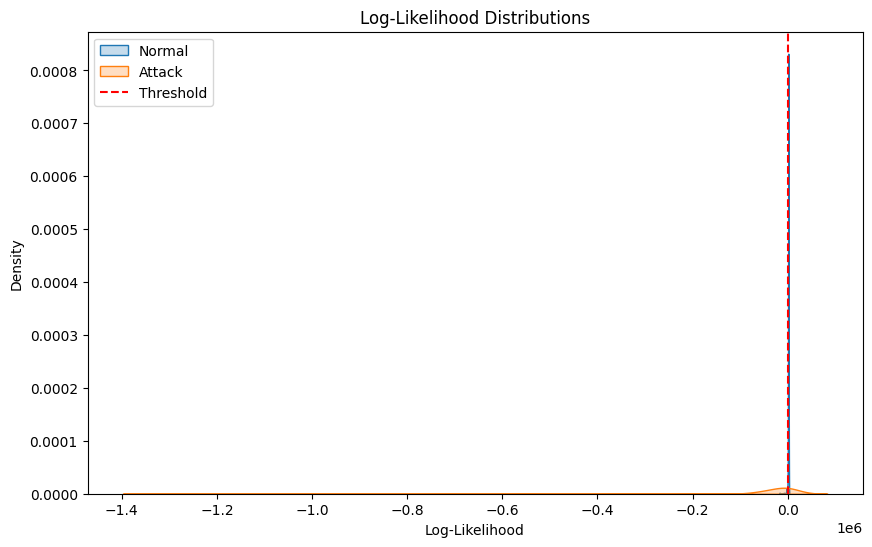

In [13]:
plt.figure(figsize=(10,6))
sns.kdeplot(normal_scores, label='Normal', fill=True)
sns.kdeplot(attack_scores, label='Attack', fill=True)
plt.axvline(threshold, color='red', linestyle='--', label='Threshold')
plt.title('Log-Likelihood Distributions')
plt.xlabel('Log-Likelihood')
plt.legend()
plt.show()

## Part II: CESNET-TimeSeries24 (Sequential data)

As I showed in the previous section, this initial dataset is fundamentally misaligned with HMM assumptions. Let's try traffic anonaly detection on a more suitable datset: CESNET-TimeSeries24: Time Series Dataset for Network Traffic Anomaly Detection and Forecasting (https://zenodo.org/records/13382427)

**Why is it better?**

This dataset is explicitly designed for network traffic time-series analysis. Unlike UNSW-NB15, here observations are temporally ordered. This makes it far more appropriate for HMM-based modeling.


# Data Preprocessing and EDA

In [14]:
df_raw = pd.read_csv('./content/42.csv')
print(df_raw.shape)
df_raw.info()

(6717, 19)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6717 entries, 0 to 6716
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id_time                6717 non-null   int64  
 1   n_flows                6717 non-null   int64  
 2   n_packets              6717 non-null   int64  
 3   n_bytes                6717 non-null   int64  
 4   sum_n_dest_asn         6717 non-null   int64  
 5   average_n_dest_asn     6717 non-null   float64
 6   std_n_dest_asn         6717 non-null   float64
 7   sum_n_dest_ports       6717 non-null   int64  
 8   average_n_dest_ports   6717 non-null   float64
 9   std_n_dest_ports       6717 non-null   float64
 10  sum_n_dest_ip          6717 non-null   int64  
 11  average_n_dest_ip      6717 non-null   float64
 12  std_n_dest_ip          6717 non-null   float64
 13  tcp_udp_ratio_packets  6717 non-null   float64
 14  tcp_udp_ratio_bytes    6717 non-null   float6

In [15]:
df_raw.head()

,id_time,n_flows,n_packets,n_bytes,sum_n_dest_asn,average_n_dest_asn,std_n_dest_asn,sum_n_dest_ports,average_n_dest_ports,std_n_dest_ports,sum_n_dest_ip,average_n_dest_ip,std_n_dest_ip,tcp_udp_ratio_packets,tcp_udp_ratio_bytes,dir_ratio_packets,dir_ratio_bytes,avg_duration,avg_ttl
0,0,1772,15608,5755028,207,9.00,4.18,333,14.48,7.75,456,19.83,12.65,0.96,0.97,0.45,0.50,5.96,83.93
1,1,2621,72477,65172204,235,9.79,5.07,489,20.38,13.89,699,29.12,25.74,0.98,0.99,0.46,0.50,6.56,77.39
2,2,5088,205075,206247796,309,12.88,9.75,659,27.46,56.42,1448,60.33,72.73,0.99,1.00,0.50,0.53,5.82,79.15
3,3,15221,925605,789102731,374,15.58,18.22,278,11.58,5.05,2787,116.12,190.86,1.00,1.00,0.51,0.51,5.05,84.96
4,4,15160,673757,575854378,373,16.22,18.04,242,10.52,3.13,2814,122.35,193.14,0.99,1.00,0.47,0.50,6.27,78.91


Let's get rid of useless or duplicating features

In [16]:
df = df_raw.drop(columns=[ # drop redundant / ID-like features
    "id_time",
    "sum_n_dest_asn", "sum_n_dest_ports", "sum_n_dest_ip",
    "std_n_dest_asn", "std_n_dest_ports", "std_n_dest_ip"
])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6717 entries, 0 to 6716
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   n_flows                6717 non-null   int64  
 1   n_packets              6717 non-null   int64  
 2   n_bytes                6717 non-null   int64  
 3   average_n_dest_asn     6717 non-null   float64
 4   average_n_dest_ports   6717 non-null   float64
 5   average_n_dest_ip      6717 non-null   float64
 6   tcp_udp_ratio_packets  6717 non-null   float64
 7   tcp_udp_ratio_bytes    6717 non-null   float64
 8   dir_ratio_packets      6717 non-null   float64
 9   dir_ratio_bytes        6717 non-null   float64
 10  avg_duration           6717 non-null   float64
 11  avg_ttl                6717 non-null   float64
dtypes: float64(9), int64(3)
memory usage: 629.8 KB


Let's split the data into train and test datasets, there is no target column for Markov chains here. Then we will standartize the data like we did with the 'bad' dataset.

In [17]:
X_train, X_test = train_test_split(df, test_size=0.2, shuffle=False)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Model Training
### Important modeling limitation

Although the data is sequential, we still don't know the true regime boundaries. As a result:

- The HMM is trained on one long sequence
- Latent states represent statistical density regions, not attack states
- This already limits anomaly interpretability

This is a structural limitation, not an implementation error


In [18]:
models = []
scores = []

for n in range(2, 7):
    model = GaussianHMM(
        n_components=n,
        covariance_type="diag",
        n_iter=500,
        random_state=42
    )
    model.fit(X_train_scaled)
    scores.append(model.score(X_train_scaled))
    models.append(model)

best_model = models[np.argmax(scores)]
best_model

GaussianHMM(n_components=6, n_iter=500, random_state=42)

As wee can see, the best model has 6 components. This is expected as likelihood-based model usually favors more complex models.

To show that even the best-fitting Gaussian HMM struggles conceptually, I intentionally avoid AIC/BIC here.




# Feature Engineering:

To use this data for HMM, we need to create state sequences. Let's use a custom function from `HMMlearn_utils.py` for that. We need to segment our data into 24h windows and then evaluate the score of each segment for the distribution to find anomalies

In [106]:
train_segments = utils.create_segments(X_train_scaled, window_size=24, overlap=12)
train_scores = utils.compute_likelihoods(best_model, train_segments)

threshold = np.percentile(train_scores, 3)
threshold

np.float64(-492.42139997904997)

# Visualization

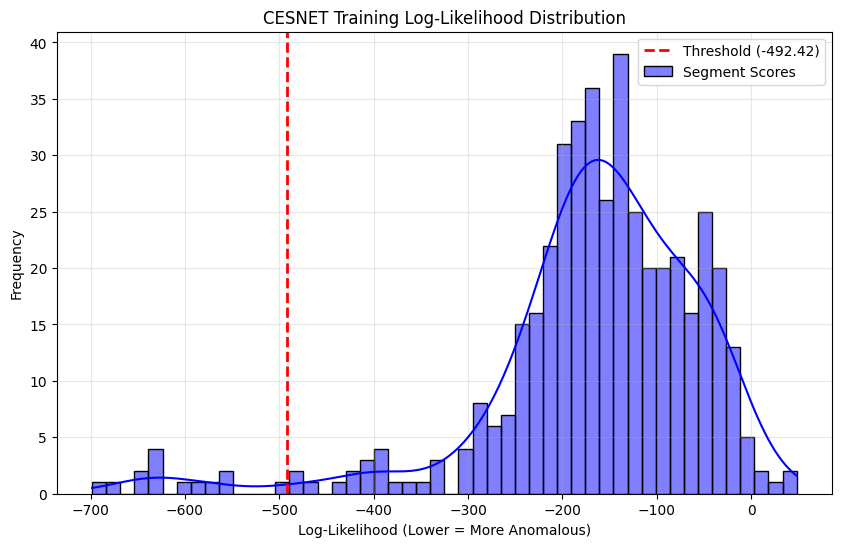

In [107]:
utils.plot_likelihood_distribution(
    train_scores,
    threshold,
    title="CESNET Training Log-Likelihood Distribution"
)

Candidate Percentiles: [ 1  2  3  4  5  6  7  8  9 10]
Scores at Percentiles: [np.float64(-2771.437740198593), np.float64(-1305.6272199115065), np.float64(-437.7890220280038), np.float64(-190.0293750921605), np.float64(-23.2310581907898), np.float64(225.18220238468237), np.float64(305.77938948999116), np.float64(380.7350752382635), np.float64(458.37217674496713), np.float64(545.7385455097675)]
Score Differences (Drop): [1465.81052029  867.83819788  247.75964694  166.7983169   248.41326058
   80.59718711   74.95568575   77.63710151   87.36636876]
Recommended Best Percentile (P): 8
Recommended Best Threshold (Score): 380.7350752382635


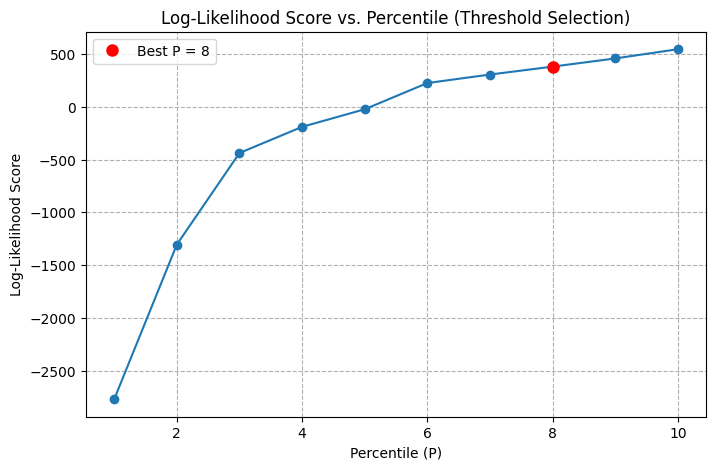

In [108]:
percentile_range = np.arange(1, 11) # 1st through 10th percentiles
scores_at_percentiles = [np.percentile(normal_scores, p) for p in percentile_range]
score_diffs = np.diff(scores_at_percentiles)
best_p_index = np.argmin(score_diffs)

best_p = percentile_range[best_p_index + 1]
best_threshold = scores_at_percentiles[best_p_index + 1]

print(f"Candidate Percentiles: {percentile_range}")
print(f"Scores at Percentiles: {scores_at_percentiles}")
print(f"Score Differences (Drop): {score_diffs}")
print(f"Recommended Best Percentile (P): {best_p}")
print(f"Recommended Best Threshold (Score): {best_threshold}")


plt.figure(figsize=(8, 5))
plt.plot(percentile_range, scores_at_percentiles, marker='o', linestyle='-')
plt.plot(best_p, best_threshold, 'ro', markersize=8, label=f'Best P = {best_p}')
plt.title('Log-Likelihood Score vs. Percentile (Threshold Selection)')
plt.xlabel('Percentile (P)')
plt.ylabel('Log-Likelihood Score')
plt.grid(True, linestyle='--')
plt.legend()
plt.savefig("percentile_selection.png")

# Evaluation and Anomaly Detection:

Let's find the test scores using the same segmentation parameters. Then we will use it for flag anomalies

The CESNET dataset does not provide fine-grained anomaly labels.

To get quantitative evaluation, let's inject synthetic anomalies. These simulations are intentionally simple and are used only to test sensitivity, not realism. They are not meant to reflect realistic attacks, only to test sensitivity to abrupt distributional shifts.


In [109]:
X_test_sim, anomaly_starts = utils.simulate_anomalies(X_test)

X_test_sim_scaled = scaler.transform(X_test_sim)
test_segments = utils.create_segments(X_test_sim_scaled, window_size=24, overlap=12)
test_scores = utils.compute_likelihoods(best_model, test_segments)

preds = (test_scores < threshold).astype(int)

print(f"Total test segments scored: {len(test_scores)}")
print(f"Total segments flagged as anomalies: {np.sum(preds)}")

Total test segments scored: 111
Total segments flagged as anomalies: 21


Let's view all the segment sequence we have to find anomalies

In [110]:
window_size = 24
overlap = 12
step = window_size - overlap

original_start_indices = X_test.index[0]

segment_start_indices = []
for i in range(0, len(X_test_scaled) - window_size + 1, step):
    segment_start_indices.append(X_test.index[i])

# creating a DataFrame to hold the scores and flags mapped to their starting time index
results_df = pd.DataFrame({
    'start_index': segment_start_indices,
    'log_likelihood_score': test_scores,
    'anomaly_flag': preds
})

print("\n--- Detected Anomalies (First 5) ---")
print(results_df[results_df['anomaly_flag'] == 1].head())

segment_sequence = results_df.index.values
segment_sequence


--- Detected Anomalies (First 5) ---
   start_index  log_likelihood_score  anomaly_flag
1         5385         -5.572950e+02             1
3         5409         -3.247344e+06             1
4         5421         -5.954119e+06             1
5         5433         -2.707487e+06             1
7         5457         -4.935211e+02             1


array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110])

In [111]:
anomalies = results_df[results_df['anomaly_flag'] == 1] # Filter the DataFrame for flagged points
print(anomalies.head())

   start_index  log_likelihood_score  anomaly_flag
1         5385         -5.572950e+02             1
3         5409         -3.247344e+06             1
4         5421         -5.954119e+06             1
5         5433         -2.707487e+06             1
7         5457         -4.935211e+02             1


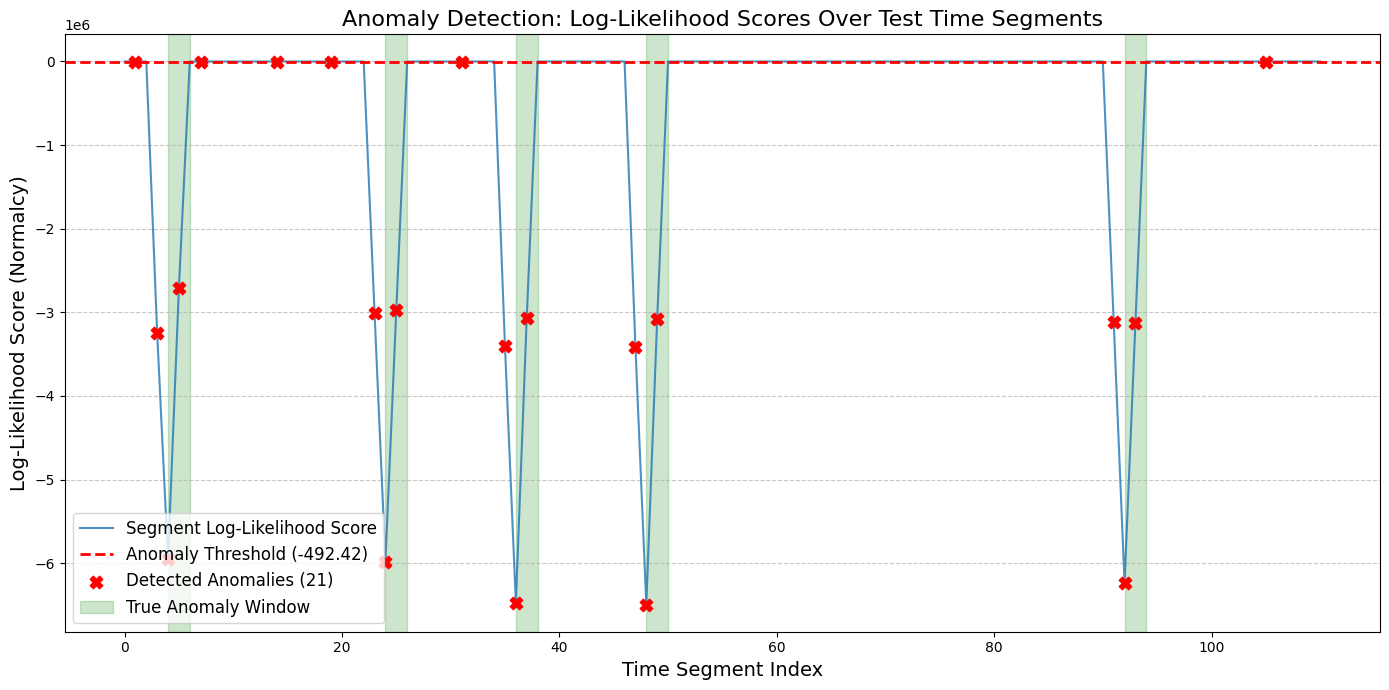

In [112]:
true_segment_indices = [x // 12 for x in anomaly_starts]


utils.plot_anomaly_detection(
    segment_indices=np.arange(len(test_scores)),
    scores=test_scores,
    threshold=threshold,
    true_anomaly_indices=true_segment_indices
)

In [113]:
# let's approximate ground truth
y_true = np.zeros(len(test_scores))
for start in anomaly_starts:
    y_true[start:start+2] = 1  # coarse alignment

print(classification_report(y_true, preds, target_names=["Normal", "Anomaly"]))

              precision    recall  f1-score   support

      Normal       1.00      0.83      0.90       109
     Anomaly       0.10      1.00      0.17         2

    accuracy                           0.83       111
   macro avg       0.55      0.91      0.54       111
weighted avg       0.98      0.83      0.89       111


## Interpretation of anomaly detection results

Classification results show a critical failure mode of likelihood-based HMM anomaly detection.

While the model achieves perfect recall (1.00) for anomalies, it comes at the cost of extremely poor precision (0.10). The model simply panics and flags many normal windows as anomalous.

This behavior is typical for density-based detectors applied to complex, non-stationary data. In practice, this means that nearly all predicted anomalies are false positives. Not good :(

Although overall accuracy is 83%, it's misleading becuase of severe class imbalance. The macro-averaged F1 score (0.54) is more honest in showing HMM's inability to balance detection sensitivity with operational usability.

These results align with what we discussed in `HMMlearn.API.ipynb` that Gaussian HMMs are poorly suited for reliable anomaly detection in modern network traffic, even when trained on sequential data

## Final conclusions

This project demonstrates that:

- Gaussian HMMs can model **coarse temporal regularities**
- They fail to reliably detect anomalies in complex network traffic
- Likelihood-based anomaly detection is poorly aligned with malicious behavior
- Violated assumptions (Gaussianity, Markovianity, stationarity) dominate results

**Conclusion:**  
The poor performance observed is not due to implementation error, but because of a fundamental mismatch between HMM assumptions and real-world network traffic dynamics.

This negative result is itself informative and highlights the importance of model–data alignment
